# I. Import các thư viện cần thiết

In [1]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [85]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Natural Language Processing (NLP)
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models & Pipelines
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, metrics
from sklearn.pipeline import Pipeline

# Model Evaluation & Metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.model_selection import GridSearchCV

# Feature Engineering & Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Hyperparameter Tuning
import optuna


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# II. Load dữ liệu

In [5]:
data = pd.read_csv('/content/drive/MyDrive/NLP/Banking Sentiment Analyst /bank_reviews3.csv')

In ra số chiều của dữ liệu

In [6]:
print(data.shape)

(1000, 10)


In ra 5 dòng đầu của dữ liệu

In [7]:
data.head()

,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


In [8]:
data.describe()

,rating,useful_count
count,1000.000000,1000.000000
mean,4.351500,2.752000
std,0.940788,7.638904
min,0.500000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,2.000000
max,5.000000,133.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                996 non-null    object 
 1   date                  1000 non-null   object 
 2   address               1000 non-null   object 
 3   bank                  1000 non-null   object 
 4   rating                1000 non-null   float64
 5   review_title_by_user  1000 non-null   object 
 6   review                1000 non-null   object 
 7   bank_image            1000 non-null   object 
 8   rating_title_by_user  1000 non-null   object 
 9   useful_count          1000 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 78.2+ KB


In [10]:
data.drop(columns=['bank_image'], axis=1, inplace=True)

# III. Tiền xử lí

In [11]:
numAddress = data['address'].nunique()
numBank = data['bank'].nunique()

print(f'Bảng đánh giá được thu thập từ {numBank} ngân hàng khác nhau ở {numAddress} nơi khác nhau tại Ấn độ.')
print('Các ngân hàng đó là: ', data.bank.unique())

Bảng đánh giá được thu thập từ 10 ngân hàng khác nhau ở 107 nơi khác nhau tại Ấn độ.
Các ngân hàng đó là:  ['SBI' 'Axis Bank' 'HDFC Bank' 'review' 'IDBI' 'Kotak' 'IndusInd Bank'
 'Canara Bank' 'Citibank' 'Punjab National Bank']


In [12]:
data['bank'].replace('review','Unknow', inplace=True)

In [13]:
continousCol = []
categoricalCol = []
for col in data.columns:
    if data[col].dtype == 'object':
        categoricalCol.append(col)
    else:
        continousCol.append(col)

In [14]:
continousCol

['rating', 'useful_count']

In [15]:
categoricalCol

['author',
 'date',
 'address',
 'bank',
 'review_title_by_user',
 'review',
 'rating_title_by_user']

# IV.EDA

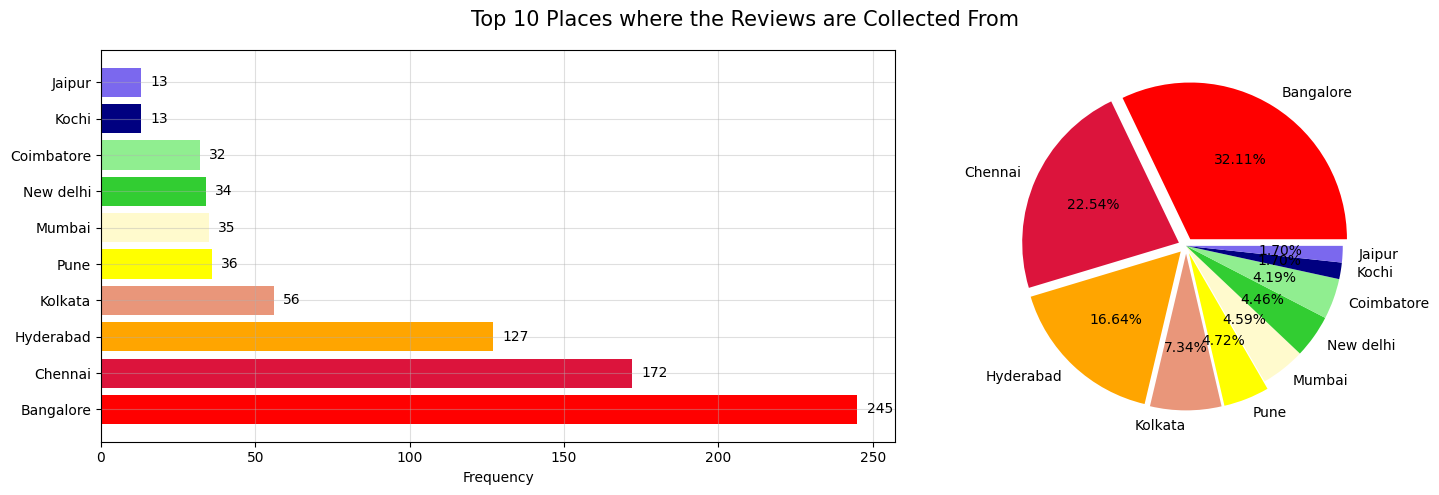

In [16]:
address = data['address'].value_counts().sort_values(ascending=False)[:10]

colors = ['red','crimson','orange','darksalmon','yellow','lemonchiffon','limegreen','lightgreen','navy','mediumslateblue']
explodes = ([0.05]*5) + ([0]*5)

# visualization (top 10 places where the reviews are collected from)
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=address.index, width=address.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (address):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(address.values, labels=address.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Top 10 Places where the Reviews are Collected From', fontsize=15)
plt.tight_layout()
plt.show()

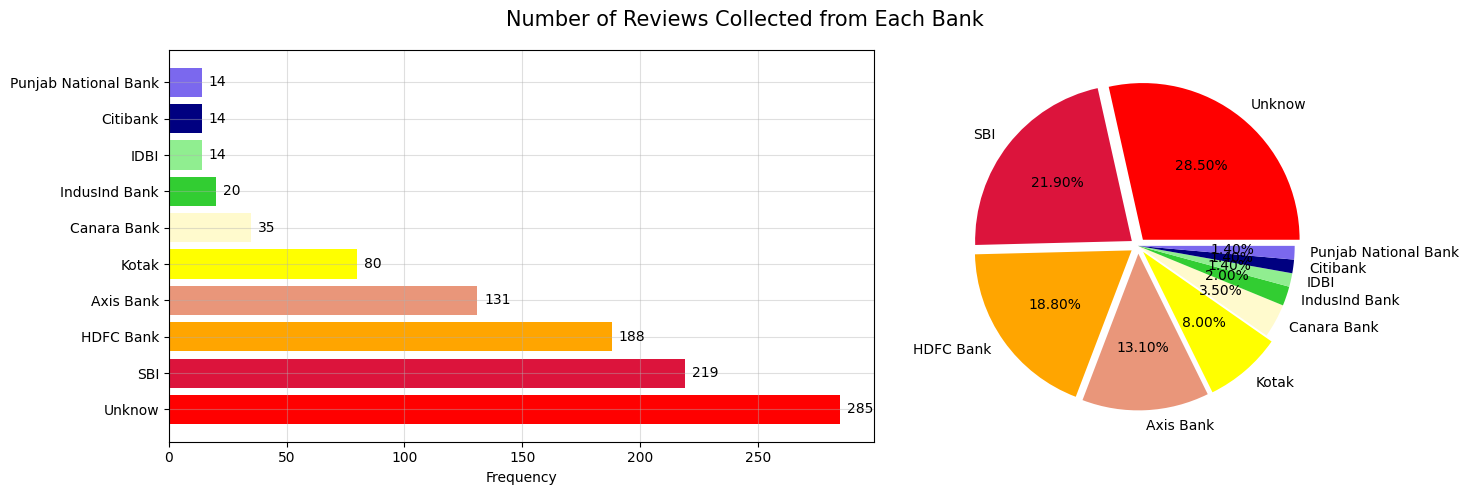

In [17]:
# distribution of the data by 'bank'
bank = data['bank'].value_counts().sort_values(ascending=False)

# visualization in bar chart and pie chart
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=bank.index, width=bank.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (bank):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(bank.values, labels=bank.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Number of Reviews Collected from Each Bank', fontsize=15)
plt.tight_layout()
plt.show()

,count
rating,
5.0,550
4.0,257
3.0,71
4.5,45
2.0,30
3.5,21
1.0,13
0.5,10
2.5,2


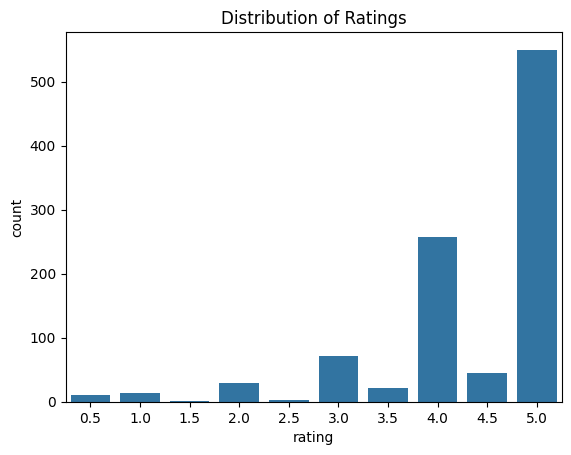

In [18]:
sns.countplot(x='rating', data=data)
plt.title('Distribution of Ratings')
data['rating'].value_counts()

Text(0, 0.5, 'Frequency')

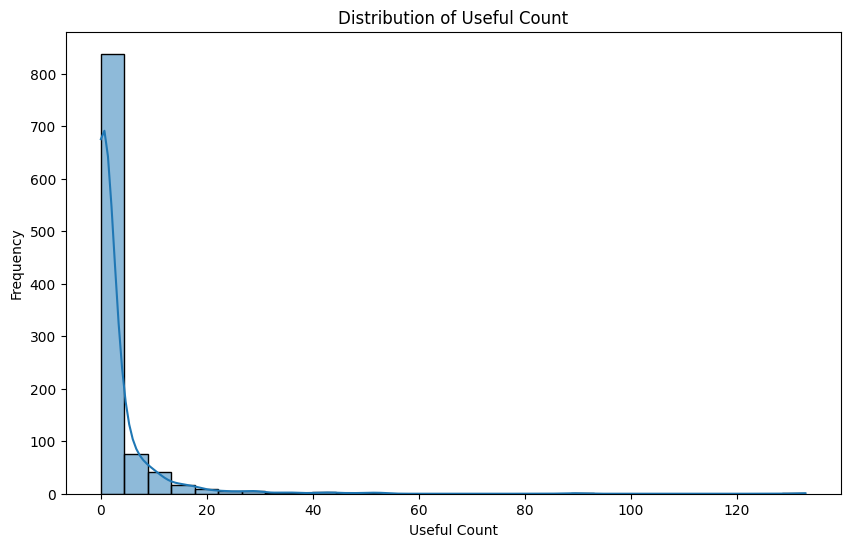

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data['useful_count'], bins=30, kde=True)
plt.title('Distribution of Useful Count')
plt.xlabel('Useful Count')
plt.ylabel('Frequency')

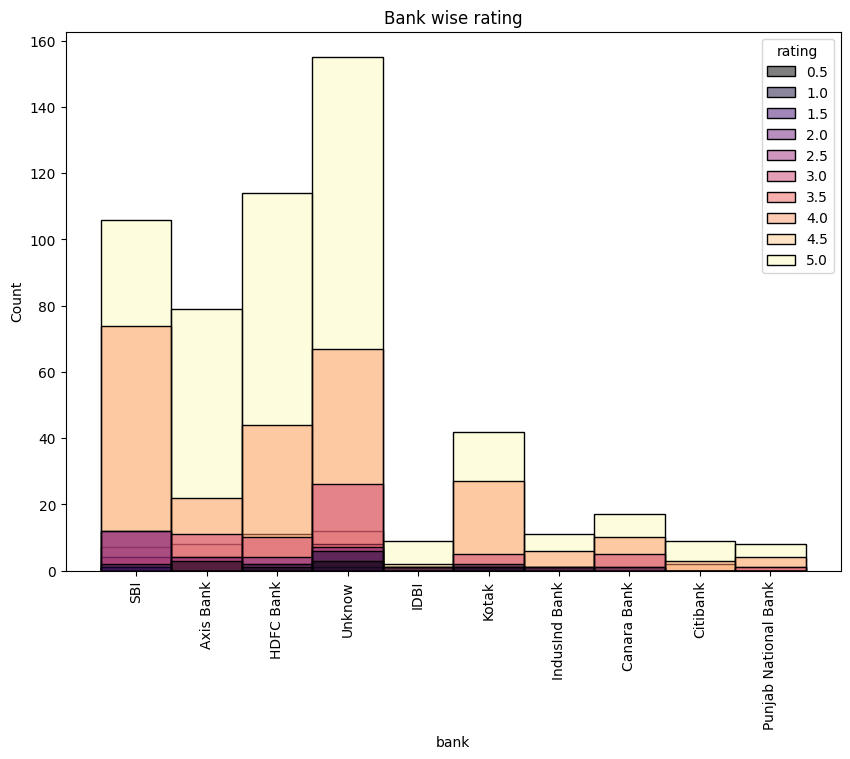

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=data, x='bank', hue='rating', palette='magma')
plt.xticks(rotation=90)
plt.title('Bank wise rating')
plt.show()

In [21]:
from plotly.express import line
line(data_frame=data.groupby(by='date').size().reset_index(), x='date', y=0)

In [22]:
data['review'] = data['review'].str.replace('[^a-zA-Z0-9\s]', '')

Text(0.5, 1.0, 'Word Cloud for Reviews')

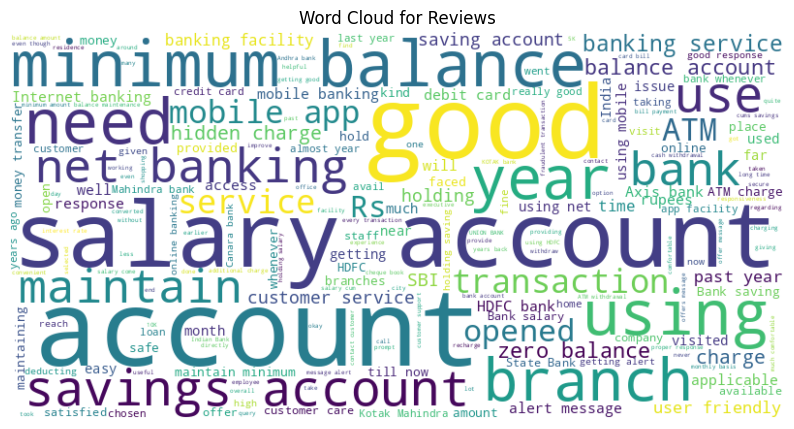

In [23]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(' '.join(data['review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Reviews')

In [24]:
# initialize the object of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [25]:
# calculate the polarity scores of the review
data['polarity'] = data['review'].apply(sia.polarity_scores)
data['compound'] = data['polarity'].apply(lambda x: x.get('compound'))

In [26]:
# define a function to perform the sentiment categorization
def categorize(score):
    if score < 0:
        return 'To be Improved'
    elif score > 0.8:
        return 'Blown Away'
    else:
        return 'Neutral'

In [27]:
# insert a new column 'Sentiment_Category' by categorized the sentiment based on the compound score
data['Sentiment_Category'] = data['compound'].apply(categorize)

# view the first 5 rows of the data after new columns inserted
data.head()

,author,date,address,bank,rating,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,Great!,133,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.7264,Neutral
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",Blown Away!,89,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",0.7165,Neutral
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,Blown Away!,48,"{'neg': 0.08, 'neu': 0.785, 'pos': 0.135, 'com...",0.4588,Neutral
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,Blown Away!,52,"{'neg': 0.042, 'neu': 0.849, 'pos': 0.108, 'co...",0.5267,Neutral
4,R,"Mar 20, 2020",Bangalore,Unknow,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",Blown Away!,22,"{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",0.7357,Neutral


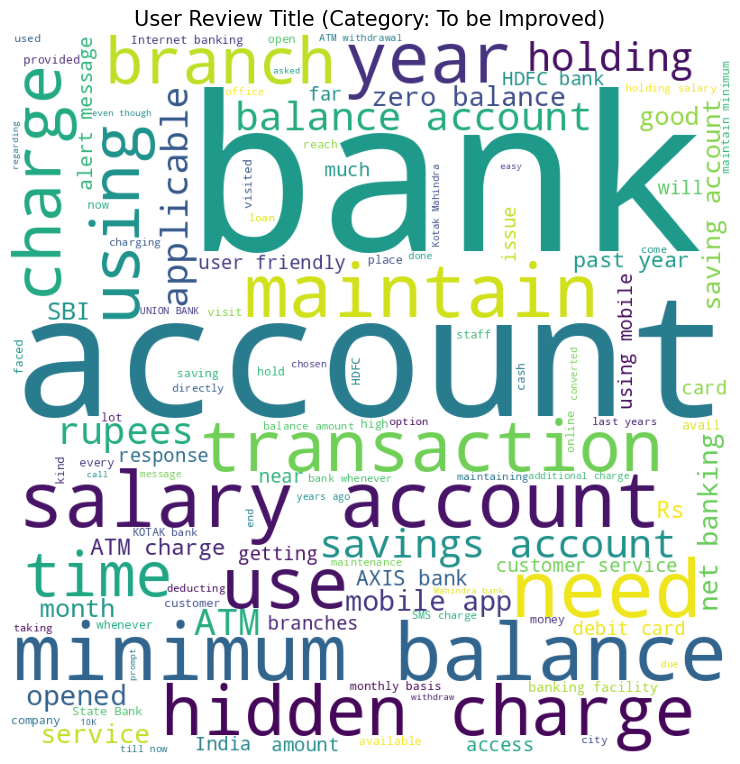

In [28]:
data_copy = data.copy()
data_copy = data[data['Sentiment_Category']=='To be Improved']

combined_tobeImproved = ' '.join(data_copy['review'])


# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(combined_tobeImproved)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

In [29]:
common_words = ['bank', 'account','salary','saving','savings','rupees']

pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, common_words)) + r')\b', flags=re.IGNORECASE)
filtered_string = pattern.sub('', combined_tobeImproved)

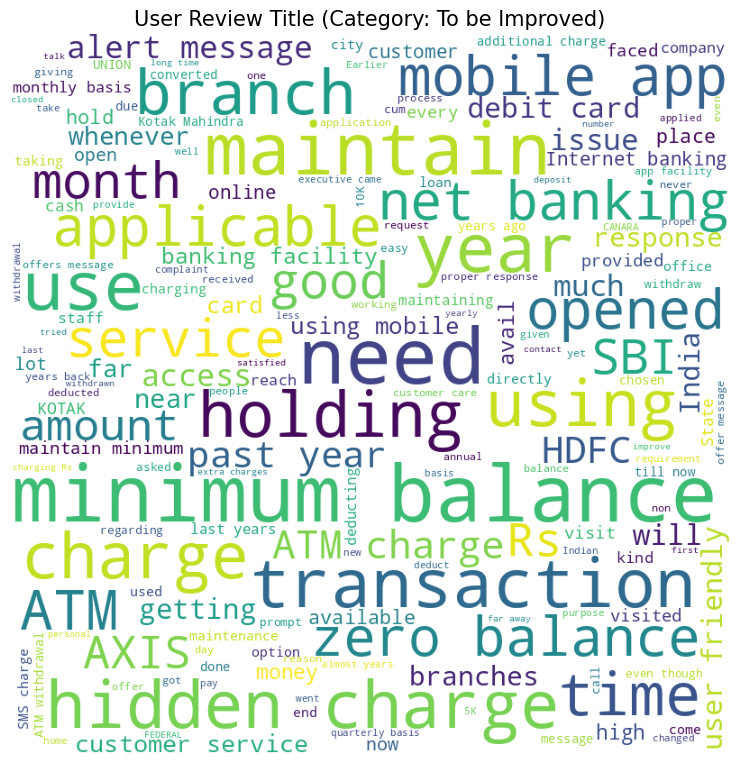

In [30]:
# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(filtered_string)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

# V.Build model


In [31]:
X = data.drop(columns=['rating'])
y = data[['rating']]

In [32]:
y.value_counts()

,count
rating,
5.0,550
4.0,257
3.0,71
4.5,45
2.0,30
3.5,21
1.0,13
0.5,10
2.5,2


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [34]:
temp = pd.concat([X_train, y_train], axis=1)
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
253,CHARLES,"Feb 21, 2020",Chennai,SBI,"""Good to have the account in SBI""",For the last 2.5 years I'm using the salary ac...,Blown Away!,0,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.8442,Blown Away,5.0
598,R,"Jan 09, 2020",Bangalore,SBI,"""Need to improve in customer service""",I will not recommend SBI account to anyone bec...,Expected more,1,"{'neg': 0.057, 'neu': 0.874, 'pos': 0.069, 'co...",0.3877,Neutral,2.0
181,J S T,"Mar 01, 2020",Ahmedabad,HDFC Bank,"""Stable and reliable bank""",I have opened the savings account from HDFC an...,Blown Away!,1,"{'neg': 0.04, 'neu': 0.96, 'pos': 0.0, 'compou...",-0.2732,To be Improved,5.0
950,PAGADALA,"Dec 03, 2019",Warangal,HDFC Bank,"""Need to decrease charges""",I have been holding savings account with HDFC ...,Satisfactory,1,"{'neg': 0.091, 'neu': 0.746, 'pos': 0.163, 'co...",0.7347,Neutral,3.0
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,"""Excellent service""",I have my salary bank account in HDFC bank for...,Blown Away!,52,"{'neg': 0.042, 'neu': 0.849, 'pos': 0.108, 'co...",0.5267,Neutral,5.0


In [35]:
testData = pd.concat([X_test, y_test], axis=1)
testData.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
154,ANONYMOUS,"Mar 03, 2020",Kolkata,Unknow,"""Good Account""",Digi bank savings account is really good to us...,Excellent!,2,"{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.4939,Neutral,4.5
529,KA,"Jan 20, 2020",Hyderabad,HDFC Bank,"""Good account """,I have been using salary account from HDFC ban...,Satisfactory,0,"{'neg': 0.082, 'neu': 0.821, 'pos': 0.097, 'co...",0.2023,Neutral,3.0
13,VIGNESH,"Mar 19, 2020",Chennai,Unknow,"""Need to improve their service""",Indian Bank cash deposit machine is not conven...,Satisfactory,30,"{'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'comp...",0.6908,Neutral,3.0
570,KI,"Jan 14, 2020",Hyderabad,HDFC Bank,"""Need to decrease charge""",I have opened a salary account from HDFC bank...,Blown Away!,2,"{'neg': 0.04, 'neu': 0.928, 'pos': 0.032, 'com...",-0.1027,To be Improved,5.0
106,SH,"Mar 10, 2020",Pune,HDFC Bank,"""Good """,I am holding a savings account for my persona...,Satisfactory,1,"{'neg': 0.107, 'neu': 0.839, 'pos': 0.054, 'co...",-0.2960,To be Improved,3.0


In [36]:
temp.shape

(750, 12)

In [37]:
testData.shape

(250, 12)

In [38]:
le = LabelEncoder()
for col in categoricalCol:
    temp[col] = le.fit_transform(temp[col])
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
253,89,46,13,8,128,67,1,0,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.8442,Blown Away,5.0
598,334,62,7,8,169,554,3,1,"{'neg': 0.057, 'neu': 0.874, 'pos': 0.069, 'co...",0.3877,Neutral,2.0
181,167,83,1,3,246,487,1,1,"{'neg': 0.04, 'neu': 0.96, 'pos': 0.0, 'compou...",-0.2732,To be Improved,5.0
950,311,1,93,3,155,403,8,1,"{'neg': 0.091, 'neu': 0.746, 'pos': 0.163, 'co...",0.7347,Neutral,3.0
3,242,102,71,3,69,446,1,52,"{'neg': 0.042, 'neu': 0.849, 'pos': 0.108, 'co...",0.5267,Neutral,5.0


In [39]:
le = LabelEncoder()
for col in categoricalCol:
    testData[col] = le.fit_transform(testData[col])
testData.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
154,17,69,26,9,40,17,1,2,"{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.4939,Neutral,4.5
529,67,58,20,3,48,145,6,0,"{'neg': 0.082, 'neu': 0.821, 'pos': 0.097, 'co...",0.2023,Neutral,3.0
13,168,84,7,9,79,194,6,30,"{'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'comp...",0.6908,Neutral,3.0
570,70,55,20,3,70,157,0,2,"{'neg': 0.04, 'neu': 0.928, 'pos': 0.032, 'com...",-0.1027,To be Improved,5.0
106,146,75,39,3,39,65,6,1,"{'neg': 0.107, 'neu': 0.839, 'pos': 0.054, 'co...",-0.2960,To be Improved,3.0


In [40]:
# Trích xuất giá trị 'pos' từ cột 'polarity'
temp['polarity_value'] = temp['polarity'].apply(lambda x: x['pos'])  # Hoặc x['neg'] hay x['neu'] tùy theo yêu cầu


In [41]:
# Mã hóa cột Sentiment_Category
label_encoder = LabelEncoder()
temp['Sentiment_Category'] = label_encoder.fit_transform(temp['Sentiment_Category'])

# Mã hóa cột polarity thành các loại
temp['Polarity_Category'] = pd.cut(temp['polarity_value'], bins=[-1, 0.1, 0.9, 1],
                                    labels=['Negative', 'Neutral', 'Positive'])


In [42]:
# Trích xuất giá trị 'pos' từ cột 'polarity'
testData['polarity_value'] = testData['polarity'].apply(lambda x: x['pos'])  # Hoặc x['neg'] hay x['neu'] tùy theo yêu cầu


In [43]:
# Mã hóa cột Sentiment_Category
label_encoder = LabelEncoder()
testData['Sentiment_Category'] = label_encoder.fit_transform(testData['Sentiment_Category'])

# Mã hóa cột polarity thành các loại
testData['Polarity_Category'] = pd.cut(testData['polarity_value'], bins=[-1, 0.1, 0.9, 1],
                                    labels=['Negative', 'Neutral', 'Positive'])


In [44]:
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating,polarity_value,Polarity_Category
253,89,46,13,8,128,67,1,0,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.8442,0,5.0,0.136,Neutral
598,334,62,7,8,169,554,3,1,"{'neg': 0.057, 'neu': 0.874, 'pos': 0.069, 'co...",0.3877,1,2.0,0.069,Negative
181,167,83,1,3,246,487,1,1,"{'neg': 0.04, 'neu': 0.96, 'pos': 0.0, 'compou...",-0.2732,2,5.0,0.000,Negative
950,311,1,93,3,155,403,8,1,"{'neg': 0.091, 'neu': 0.746, 'pos': 0.163, 'co...",0.7347,1,3.0,0.163,Neutral
3,242,102,71,3,69,446,1,52,"{'neg': 0.042, 'neu': 0.849, 'pos': 0.108, 'co...",0.5267,1,5.0,0.108,Neutral


In [45]:
temp = temp.drop(columns=['polarity', 'Polarity_Category'])
testData= testData.drop(columns=['polarity', 'Polarity_Category'])

In [46]:
X_train = temp.drop('rating', axis=1)
y_train = temp['rating']

In [47]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [48]:
X_train

array([[-0.88130362, -0.28119314, -0.718832  , ...,  1.0423135 ,
        -1.61755313,  0.49215808],
       [ 0.74052452,  0.23302778, -0.9552899 , ...,  0.09734544,
        -0.08577933, -0.48469319],
       [-0.36496649,  0.90794274, -1.19174779, ..., -1.27073646,
         1.44599446, -1.4907042 ],
       ...,
       [ 1.70700169, -0.02408268,  1.33046976, ...,  0.89223642,
        -0.08577933,  0.46299834],
       [-1.2652466 , -1.27749617, -0.5611934 , ...,  0.47864471,
        -0.08577933, -0.16393606],
       [-1.33806338,  1.45430247,  0.22699958, ..., -1.27073646,
         1.44599446, -1.4907042 ]])

##1.PCA

In [49]:
pca = PCA(n_components = 8)
pca.fit_transform(X_train);

In [50]:
pca.explained_variance_ratio_

array([0.25160488, 0.11960615, 0.1007029 , 0.09734915, 0.09299651,
       0.08710074, 0.08119368, 0.07480212])

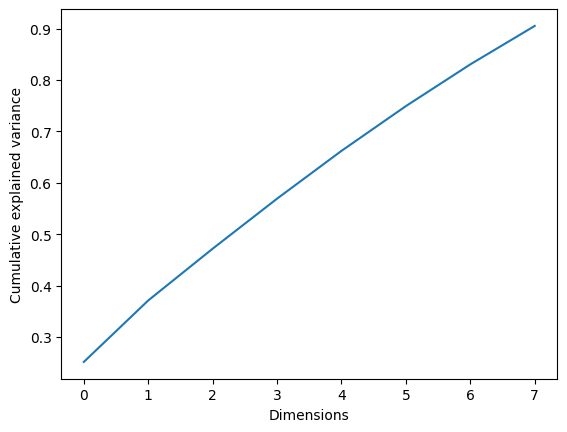

In [51]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Cumulative explained variance');

In [52]:
temp['kFold'] = -1

In [53]:
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,compound,Sentiment_Category,rating,polarity_value,kFold
253,89,46,13,8,128,67,1,0,0.8442,0,5.0,0.136,-1
598,334,62,7,8,169,554,3,1,0.3877,1,2.0,0.069,-1
181,167,83,1,3,246,487,1,1,-0.2732,2,5.0,0.000,-1
950,311,1,93,3,155,403,8,1,0.7347,1,3.0,0.163,-1
3,242,102,71,3,69,446,1,52,0.5267,1,5.0,0.108,-1


In [54]:
X_test = testData.drop('rating', axis=1)
y_test = testData['rating']

In [55]:
y_train

,rating
253,5.0
598,2.0
181,5.0
950,3.0
3,5.0
...,...
574,5.0
308,4.0
193,5.0
819,4.0


In [56]:
y_train = np.where(y_train <= 3.0, 'bad',
                   np.where(y_train >= 4.0, 'good', 'neutral'))

y_test = np.where(y_test <= 3.0, 'bad',
                  np.where(y_test >= 4.0, 'good', 'neutral'))


In [57]:
X_test = scaler.transform(X_test)

In [58]:
y_test

array(['good', 'bad', 'bad', 'good', 'bad', 'good', 'neutral', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'bad', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'neutral', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good'

## 2.Logictics Reg

In [75]:
# Huấn luyện mô hình
model = LogisticRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
pred_lr = model.predict(X_test)

In [76]:
report = classification_report(y_test, pred_lr)
print(report)

              precision    recall  f1-score   support

         bad       1.00      0.48      0.65        27
        good       0.92      1.00      0.96       218
     neutral       0.00      0.00      0.00         5

    accuracy                           0.92       250
   macro avg       0.64      0.49      0.54       250
weighted avg       0.91      0.92      0.91       250



Tối ưu siêu tham số cho logictics Reg

In [86]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],  # Lưu ý: một số thuật toán chỉ hỗ trợ l2 penalty
    'max_iter': [100, 200, 300]
}

# Khởi tạo mô hình Logistic Regression
log_reg = LogisticRegression()

# Sử dụng GridSearchCV để tìm các siêu tham số tốt nhất
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)

# Huấn luyện với bộ dữ liệu
grid_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Đánh giá mô hình với dữ liệu kiểm thử
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation accuracy: 0.9373333333333334
Test set accuracy: 0.92


In [89]:
y_pred = best_model.predict(X_test)

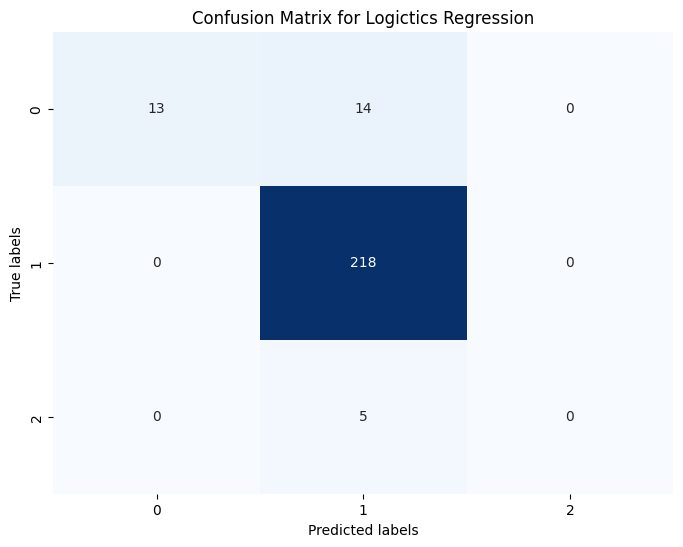

In [90]:
cm = confusion_matrix(y_test, pred_lr)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logictics R')
plt.show()

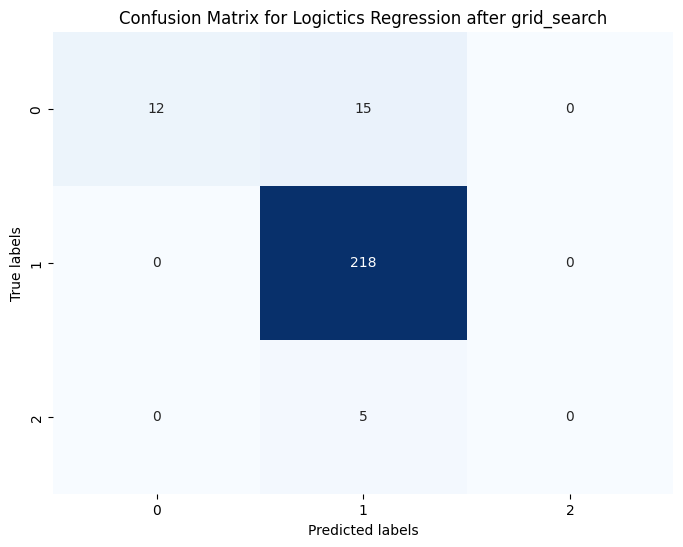

In [91]:
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logictics Regression after grid_search')
plt.show()

##3.Random Forest

In [73]:
rf_model = RandomForestClassifier(random_state=12)
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
rf_pred = rf_model.predict(X_test)

# In ra bảng report
rf_report = classification_report(y_test, rf_pred, target_names=['bad', 'good', 'neutral'])
print(rf_report)

              precision    recall  f1-score   support

         bad       1.00      0.33      0.50        27
        good       0.96      1.00      0.98       218
     neutral       0.00      0.00      0.00         5

    accuracy                           0.91       250
   macro avg       0.65      0.44      0.49       250
weighted avg       0.95      0.91      0.91       250



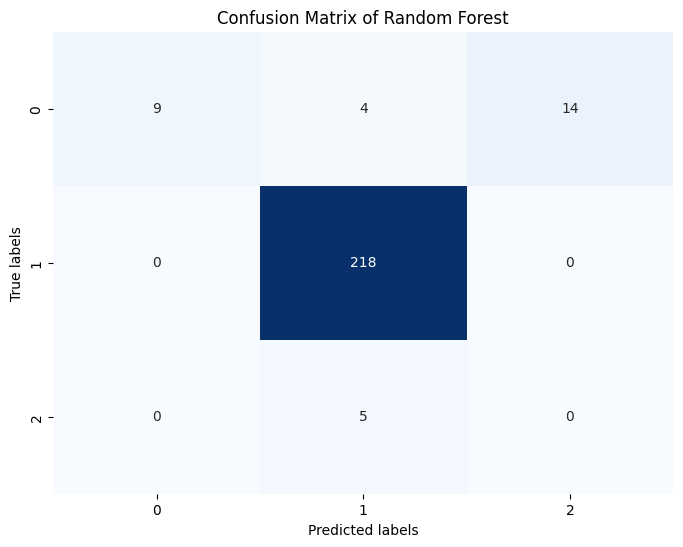

In [93]:
cm = confusion_matrix(y_test, rf_pred)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Random Forest')
plt.show()

Tuning Random Forest

In [92]:


# Định nghĩa lưới siêu tham số cần tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Số lượng cây trong rừng
    'max_depth': [10, 20, 30, None],  # Chiều sâu tối đa
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu để tách
    'min_samples_leaf': [1, 2, 4],    # Số lượng mẫu tối thiểu ở mỗi node lá
    'max_features': ['auto', 'sqrt'], # Số lượng đặc trưng khi tách
    'bootstrap': [True, False]        # Lấy mẫu với hoặc không với bootstrapping
}

# Sử dụng GridSearchCV để tìm các siêu tham số tốt nhất
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Huấn luyện mô hình với tập huấn luyện
grid_search_rf.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_rf.best_score_}")

# Đánh giá mô hình tốt nhất trên tập kiểm thử
best_rf_model = grid_search_rf.best_estimator_
rf_pred_tuned = best_rf_model.predict(X_test)

# In ra bảng report sau khi tuning
rf_report_tuned = classification_report(y_test, rf_pred_tuned, target_names=['bad', 'good', 'neutral'])
print(rf_report_tuned)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.9746666666666666
              precision    recall  f1-score   support

         bad       0.93      0.48      0.63        27
        good       0.96      1.00      0.98       218
     neutral       0.00      0.00      0.00         5

    accuracy                           0.92       250
   macro avg       0.63      0.49      0.54       250
weighted avg       0.94      0.92      0.92       250



In [96]:
y_pred_rf = best_rf_model.predict(X_test)

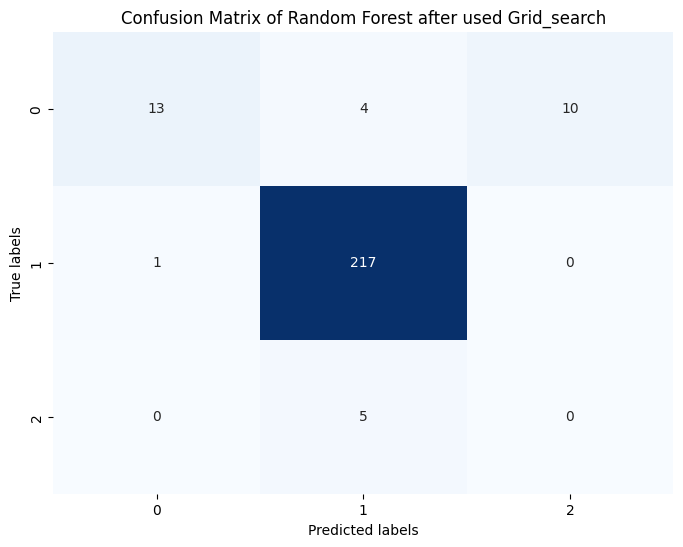

In [97]:
cm = confusion_matrix(y_test, y_pred_rf)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Random Forest after used Grid_search')
plt.show()

##4.Catboost

In [64]:

# Huấn luyện mô hình CatBoost
catboost_model = CatBoostClassifier(iterations=1000,
                                     learning_rate=0.1,
                                     depth=6,
                                     verbose=0)  # Set verbose=0 to suppress output
catboost_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
catboost_pred = catboost_model.predict(X_test)

# In ra bảng report
catboost_report = classification_report(y_test, catboost_pred, target_names=['bad', 'good', 'neutral'])
print(catboost_report)


              precision    recall  f1-score   support

         bad       0.05      0.15      0.08        27
        good       0.94      0.67      0.78       218
     neutral       0.00      0.00      0.00         5

    accuracy                           0.60       250
   macro avg       0.33      0.27      0.28       250
weighted avg       0.82      0.60      0.69       250



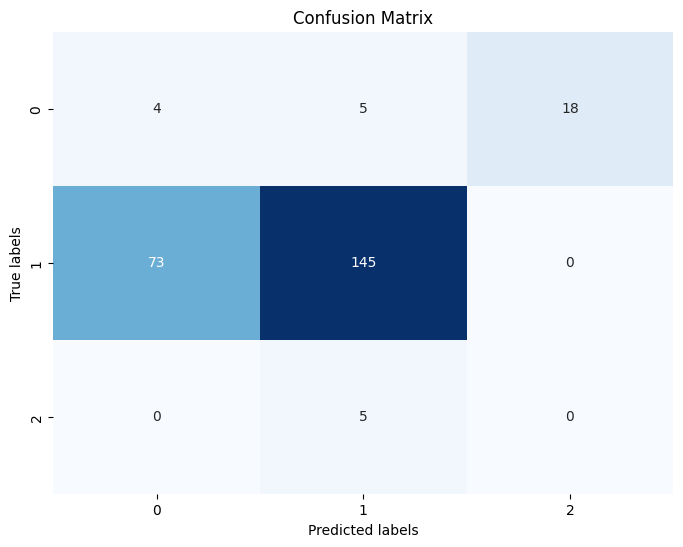

In [80]:
cm = confusion_matrix(y_test, catboost_pred)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Tuning Catboots

In [65]:
def objective(trial):
    # Hyperparameter tuning
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }

    # Train the CatBoost model
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions and calculate F1 score
    preds = model.predict(X_test)  # Assume you have a validation set
    f1 = f1_score(y_test, preds, average='weighted')

    return f1

In [66]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Adjust the number of trials as needed

[I 2024-09-30 03:11:01,002] A new study created in memory with name: no-name-6e2567d0-7e3b-426f-8649-efd4dee8de50
[I 2024-09-30 03:11:06,431] Trial 0 finished with value: 0.6866928104575164 and parameters: {'iterations': 791, 'learning_rate': 0.017445692858615303, 'depth': 6, 'l2_leaf_reg': 7.510413281699993}. Best is trial 0 with value: 0.6866928104575164.
[I 2024-09-30 03:11:34,232] Trial 1 finished with value: 0.7215151773291307 and parameters: {'iterations': 506, 'learning_rate': 0.21044279255240295, 'depth': 10, 'l2_leaf_reg': 8.373799449699595}. Best is trial 1 with value: 0.7215151773291307.
[I 2024-09-30 03:11:35,158] Trial 2 finished with value: 0.6873856828478963 and parameters: {'iterations': 446, 'learning_rate': 0.1166939563923747, 'depth': 4, 'l2_leaf_reg': 9.510312017472883}. Best is trial 1 with value: 0.7215151773291307.
[I 2024-09-30 03:11:53,041] Trial 3 finished with value: 0.683783574978754 and parameters: {'iterations': 364, 'learning_rate': 0.09799813715336649, '

In [67]:
best_params = study.best_params
print("Best parameters:", best_params)


Best parameters: {'iterations': 506, 'learning_rate': 0.21044279255240295, 'depth': 10, 'l2_leaf_reg': 8.373799449699595}


In [69]:
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

# Optionally, evaluate the model on the test set
final_preds = final_model.predict(X_test)
final_report = classification_report(y_test, final_preds, target_names=['bad', 'good', 'neutral'])
print(final_report)


0:	learn: 0.9631750	total: 89.6ms	remaining: 45.3s
1:	learn: 0.7715138	total: 146ms	remaining: 36.8s
2:	learn: 0.6710074	total: 172ms	remaining: 28.8s
3:	learn: 0.5945562	total: 249ms	remaining: 31.2s
4:	learn: 0.5424693	total: 337ms	remaining: 33.8s
5:	learn: 0.4594662	total: 428ms	remaining: 35.6s
6:	learn: 0.3841006	total: 429ms	remaining: 30.6s
7:	learn: 0.3317732	total: 518ms	remaining: 32.2s
8:	learn: 0.3124135	total: 620ms	remaining: 34.2s
9:	learn: 0.2894853	total: 725ms	remaining: 36s
10:	learn: 0.2600803	total: 826ms	remaining: 37.2s
11:	learn: 0.2368909	total: 922ms	remaining: 38s
12:	learn: 0.2237271	total: 1.02s	remaining: 38.7s
13:	learn: 0.2066185	total: 1.11s	remaining: 39.1s
14:	learn: 0.1897940	total: 1.12s	remaining: 36.6s
15:	learn: 0.1812906	total: 1.21s	remaining: 37s
16:	learn: 0.1727474	total: 1.3s	remaining: 37.4s
17:	learn: 0.1579436	total: 1.4s	remaining: 37.9s
18:	learn: 0.1475042	total: 1.49s	remaining: 38.1s
19:	learn: 0.1388054	total: 1.58s	remaining: 38.

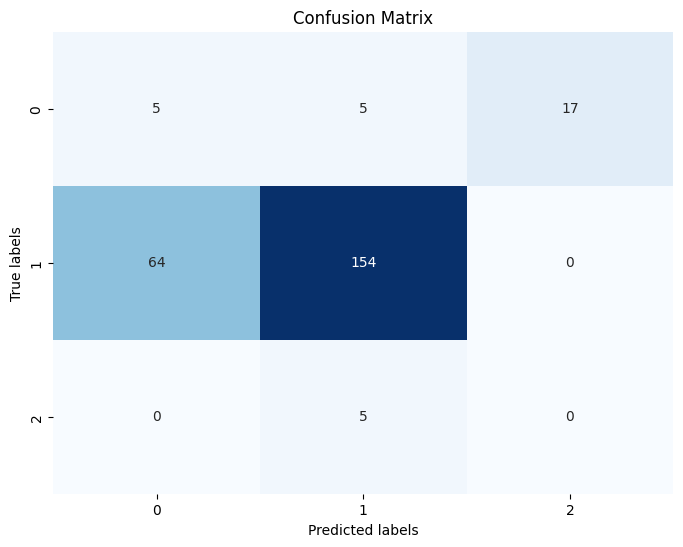

In [83]:
cm = confusion_matrix(y_test,final_preds)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [99]:
!pip install -q comet_ml gradio

import gradio as g

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.6 MB/s et

In [102]:
# Cài đặt các thư viện cần thiết
!pip install -q comet_ml gradio scikit-learn pandas
from sklearn.feature_extraction.text import CountVectorizer


# Chuyển đổi văn bản thành vectơ
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

# Huấn luyện mô hình Logistic Regression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

# Hàm dự đoán
def predict_label(input_text):
    input_vectorized = vectorizer.transform([input_text])
    prediction = model.predict(input_vectorized)
    return str(prediction[0])

# Tạo giao diện Gradio
iface = gr.Interface(fn=predict_label,
                     inputs="text",
                     outputs="text",
                     title="Dự đoán nhãn với Logistic Regression",
                     description="Nhập một đoạn văn bản và mô hình sẽ dự đoán nhãn của nó (0, 1, hoặc 2).")

# Khởi chạy giao diện
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5864db8d6fe97c1860.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
